# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [1]:
%load_ext autoreload
%autoreload 2

# Machine Learning to Detect Bedroom Occupancy
As a side analysis, this notebook explores how we can use machine learning alongside IAQ measurements from the Beacon to determine when participants are occupying their bedrooms. 

---

<a id="toc"></a>

# Table of Contents
1. Package Import
2. Notes on Anlysis
3. Notes on Data Used
4. Pre-Processing
5. [Inspection](#inspection)
6. Model Development
    1. [Logistic Regression](#lr)
    2. [Naive-Bayes](#nb)
    3. [Random Forest](#rf)
    4. [Multilayer Perceptron](#mlp)
7. [Predicting](#predicting)

## Package Import

In [2]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.analysis import occupancy_detection

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

---

# Notes on Analysis and References
Below are some of the basic steps conducted in this analysis and the references that were used in the construction of the analysis.

In [3]:
process_data = occupancy_detection.PreProcess(data_dir="../data")

## Classification
For this problem, we want to classify periods of occupancy. There are _many_ options we can chose so we have to develop a pipeline to test these ML models. The general process for this pipeline is outlined below. Speaking of _pipelines_, in this analysis we take advantage (minimally) of SKlearn's `Pipeline`. See a short discussion on [How to Use SKlearn Pipelines](https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d). 

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

### Split
We have to split the available data into a training and testing set. Luckily, we have a fair amount of observations

### Scale

### Optimize

### Train

### Predict

### Evaluate
We evaluate the classifiers with a few metrics as suggested in [Understanding Data Science Classification Metrics](https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019):

* `accuracy_score`
* `recall_score`
* `precision_score`
* `f1_score`
* `roc_auc_score`

## Troubleshooting References
Some of the references I used when troubleshooting issues:

* [Getting Non-Intersection Between DataFrames](https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe)
* [Passing Dictionary to SKlearn Models](https://stackoverflow.com/questions/33110973/pass-a-dict-to-scikit-learn-estimator)
* [Checking for Class Attribute](https://stackoverflow.com/questions/610883/how-to-know-if-an-object-has-an-attribute-in-python): While this is possible, the more Pythonic way is to _Easier to Ask for Forgiveness rather than Permission_ (EAFP) instead of _Look Before You Leap_ (LBYL).
* [Adding String to Eack Key in Dictionary](https://stackoverflow.com/questions/48681634/adding-a-string-to-all-keys-in-dictionary-python): Needed to do this because when using SKlearn's `Pipeline`, a keyword string gets added to the front of the model parameters. 
* [Select DataFrame DateTime rows within multiple periods](https://stackoverflow.com/questions/69766227/pandas-select-dataframe-rows-between-multiple-date-times): faster way to parse out rows for sleep events at such.

---

# Notes on Data Used
The necesary data are imported when insantiating a `Classify` object. 

## Beacon Data
We use two, previously-created beacon datasets:

1. **All**: All the IAQ measurements made by the beacons indexed by the timestamp.
2. **Nightly Measurements**: IAQ Measurements made by the beacons during Fitbit identified sleep events which have also been cross-referenced with GPS data to confirm participants are in the same location as the beacon during sleep events.

From these datasets, we are primarly concerned with the CO$_2$ data since increasing concentrations should be a direct result of the space being occupied. However, there are other IAQ parameters like TVOCs that we might also be able to use as input features to help improve the accuracy of the model.

We leverage IAQ data that we have already identified come from periods when participants are home and asleep -- Nightly Measurements. These data are _likely_ from periods when participants are in their bedrooms (although they could have fallen asleep on the couch, for example). Therefore, we can use these periods to label the IAQ measurements as "occupied" times. 

## Beiwe GPS Data
We also need to label IAQ data from periods when bedrooms are "unoccupied". Since the Nightly Measurements are only from Fitbit-detected sleep episodes, there are likely short periods prior to and after the episodes where the participant is occupying their bedroom. Therefore we cannot simply label all other times outside the Nightly Measurements as unoccupied. To give certainty to unoccupied periods, we should use the GPS data and label all beacon timestamps as unoccupied periods when GPS traces confirm that participants are not at home. 

## Homestay Data
We might want to just do simple occupancy detection using the homestay data rather than bedroom occupancy which can be another layer to it. 

## Participant Information
We need the participant beacon, beiwe, and fitbit IDs so we can cross-reference the various pieces of information. This dataset contains other information including the sex of the individual and the estimated volume of their bedrooms (depends on the dwelling type). 

## Fitbit Data
We don't really _need_ Fitbit data for this analysis, but we did technically use it to develop the Nightly Measurements for the Beacon so I will include this note.

---

# Pre-Processing
We need to pre-process the data in the following ways:

1. **Downsample**: I don't think a resolution of 2 minutes is necessary for this kind of analysis, but I also don't want to lose out on any important information by downsampling to too small of a resolution.
2. **Labeling**: We will have to label periods of IAQ measurements when the bedroom/home is occupied and unoccupied. 

## Resampling
We have a few different points where the data are downsampled:

* `beacon_all`: Resampled in the `init` method directly after importing.
* `beacon_nightly` Resampled in the `init` method directly after importing. However, we have to be careful because we lose the Fitbit-identified `start_time` and `end_time` for the sleep episode since those are `str` and cannot be resampled. 
* `gps_unoccupied`: Resampled once we have identified the data outside of the homestay periods

## Adding Labels
There are two types of occupancy we want to look into: `bedroom` occupancy and `home` occupancy. This process allows us to leverage the analysis that Peter conducted and just adds an extra layer of complexity which is always fun.

### Bedroom Occupancy

#### `occupied` Labels
We can include `occupied` labels by looking at the nightly beacon data. The `home` column includes a flag that denotes if GPS data confirm participants are home (1), not home (0), or weren't confirmed home by gps (-1). We want to ensure that nights are labeled when we are _certain_ participants are home so we only consider IAQ measurements when `home == 1`.

#### `unoccupied` Labels
The `unoccupied` label is determined by looking at the overlap of the available GPS data from periods outside of the homestay that Peter determined previously. 

#### Label Distribution
Checking on the labels.

In [5]:
process_data.add_bedroom_label()

In [6]:
for label in process_data.bedroom_data["bedroom"].unique():
    print(f"{label}:\t{len(process_data.bedroom_data[process_data.bedroom_data['bedroom'] == label])}")

occupied:	16898
unoccupied:	20219


<div class="alert-block alert alert-warning">
    
We actually have only a few thousand more unoccupied data points which is most likely attributed to the fact that we get to add all data points from the sleep epsidoe once we confirm the participant is home compared to only being able to label occupied data points when the GPS coordinates overlap. 
    
There are probably more novel ways to get unoccupied data points, but for right now, we will simply opt for this simplified approach.
<div>

### Home Occupancy
Just occupancy at their home - not necessarily from their bedroom

#### `occupied` Labels
Now we can just use the homestay data that Peter generated to get occupied times.

#### `unoccupied` Labels
We use the same data as before for the bedroom periods since we want to use only data that we are _sure_ came from unoccupied periods.

In [7]:
process_data.add_home_label()

In [8]:
for label in process_data.home_data["home"].unique():
    print(f"{label}:\t{len(process_data.home_data[process_data.home_data['home'] == label])}")

occupied:	42393
unoccupied:	20653


<div class="alert-block alert alert-info">
    
We don't have the same amount of unoccupied data points which is odd since we are appending the same dataframe to each of the `home_data` and `bedroom_data`. We explore why this is in the following cells.
<div>

### Discrepancy in Labeling
For some reason, the number of datapoints within the home and bedroom unoccupied datasets is different. We investigate that difference.

#### Dropping Duplicates
Within each method we have a line similar to:

```python
df.drop_duplicates(subset=["beiwe","co2"],inplace=True)
```

which drops duplicate entries that come from combining the unoccupied and occupied datastreams after resampling. Given the size of the resampling period, there might be more overlap. We now include a flag input `drop_duplicates` which helps us investigate if this line might be the issue. 

In [9]:
for option in [True,False]:
    print("DROPPING DUPLICATES:", option)
    # getting data
    process_data.add_bedroom_label(drop_duplicates=option)
    bdrm = process_data.bedroom_data.copy()
    process_data.add_home_label(drop_duplicates=option)
    hm = process_data.home_data.copy()
    # merging
    bdrm_unocc = bdrm[bdrm["bedroom"] == "unoccupied"]
    hm_unocc = hm[hm["home"] == "unoccupied"]
    combined_unocc = bdrm_unocc.reset_index().merge(hm_unocc.reset_index(),on=["beiwe","timestamp"])
    # output
    print("\tNumber of bedroom datapoints:",len(bdrm_unocc))
    print("\tNumber of home datapoints:",len(hm_unocc))
    print("\tNumber of combined datapoints:",len(combined_unocc))

DROPPING DUPLICATES: True
	Number of bedroom datapoints: 20219
	Number of home datapoints: 20653
	Number of combined datapoints: 18948
DROPPING DUPLICATES: False
	Number of bedroom datapoints: 21495
	Number of home datapoints: 22388
	Number of combined datapoints: 21495


<div class="alert-block alert alert-info">
    
We explain _some_ of the reason for the discrepancy. At least now we are getting that both datasets have the same minimum unoccupied datapoints as prescribed by the bedroom data points. Why the home dataset has 1000 or so more data points is still not clear.
<div>

#### Participants Being Removed
We only want to include participants who have both occupied and unoccupied data. Perhaps the bedroom dataset is removing a participant that the home dataset is not. 

In [10]:
process_data.add_bedroom_label(drop_duplicates=False)
bdrm = process_data.bedroom_data.copy()
process_data.add_home_label(drop_duplicates=False)
hm = process_data.home_data.copy()
print("Number of participants in the bedroom dataset:",len(bdrm["beiwe"].unique()))
print("Number of participants in the home dataset:",len(hm["beiwe"].unique()))

Number of participants in the bedroom dataset: 18
Number of participants in the home dataset: 23


<div class="alert-block alert alert-success">

We have found the issue! This finding means that some of the participants do not have Fitbit data yet still report beacon/IAQ and beiwe/gps data. 
<div>

---

<a id="inspection"></a>

[Back to ToC](#toc)
# Inspection
We want to take a quick look at the data to make sure that we are able to predict occupancy.

## CO$_2$ Distributions for Occupied vs Unoccupied Periods
The easiest comparison is to look at CO$_2$ concentrations to see if there is a noticeable difference in the distribution of measurements. However, the background concentrations could vary by participant so we need to look on a participant level.

In [11]:
process_data.set_data()

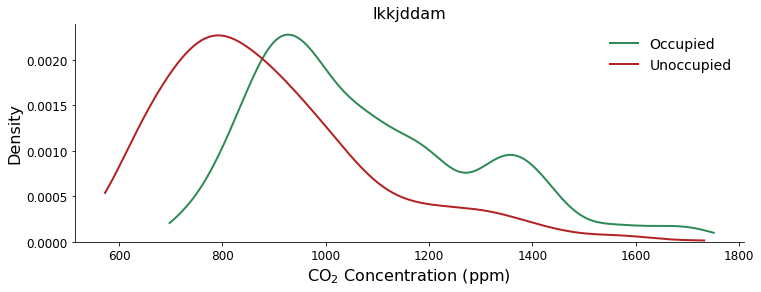

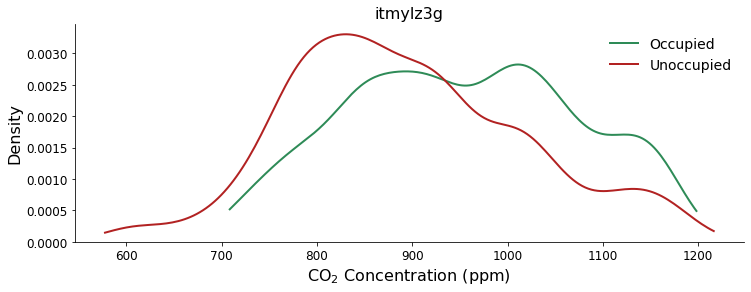

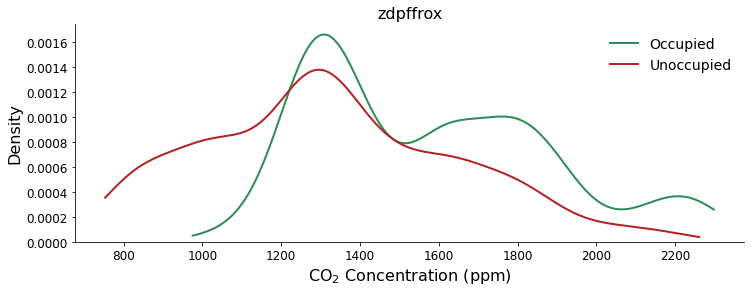

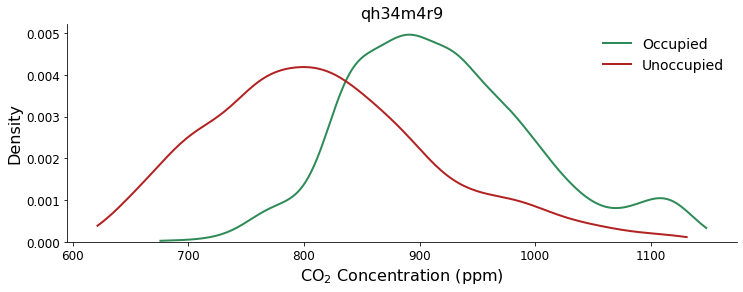

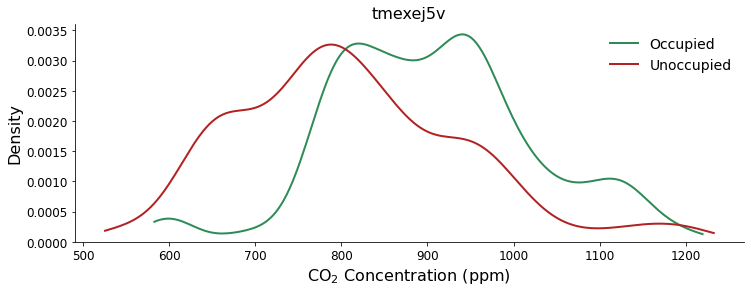

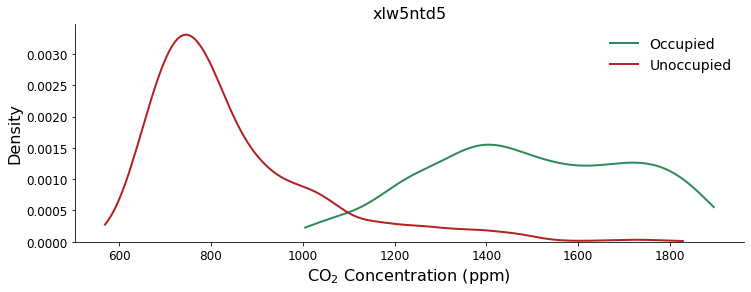

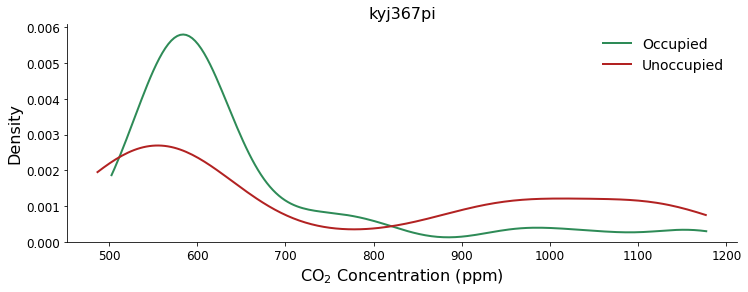

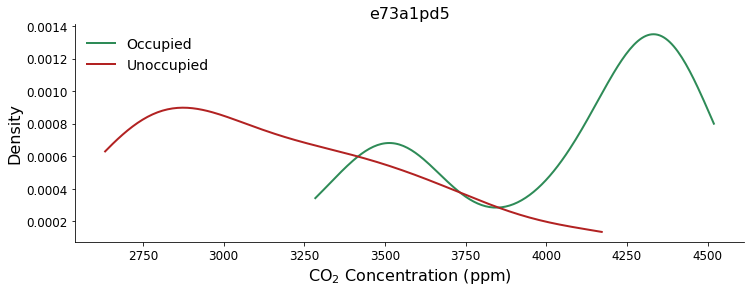

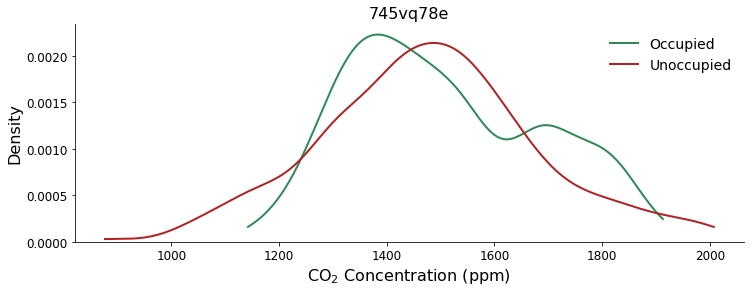

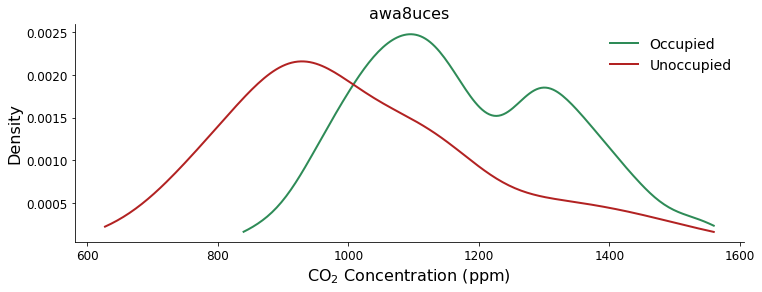

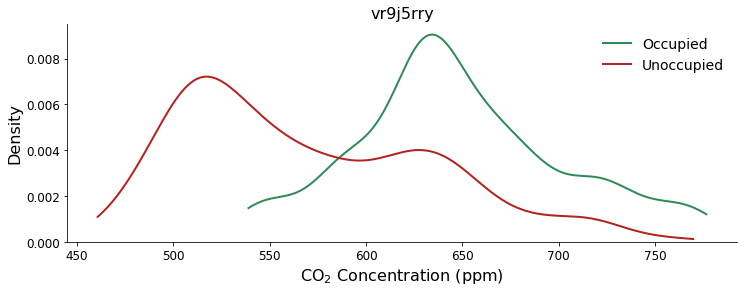

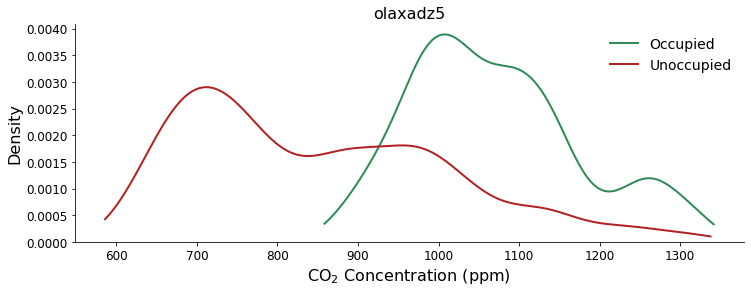

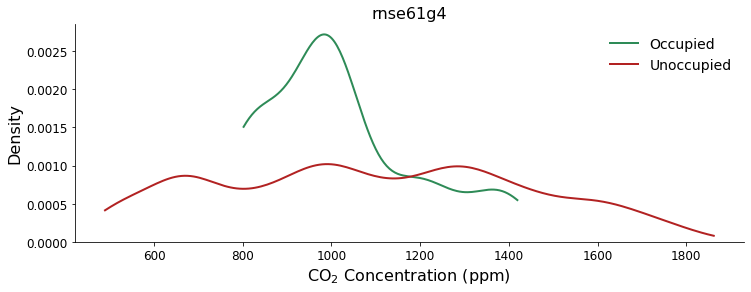

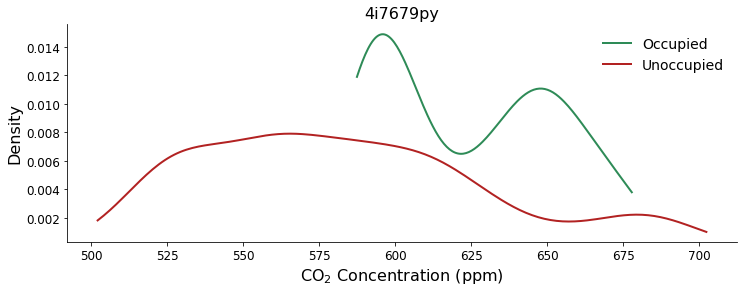

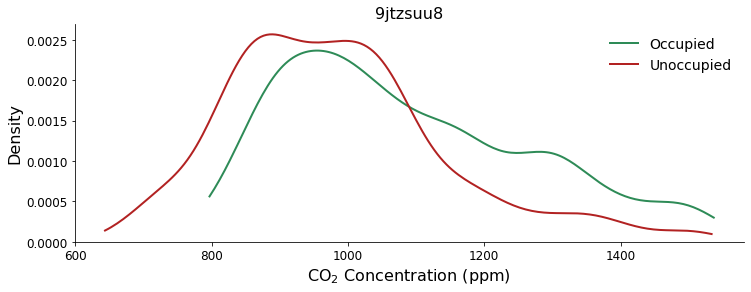

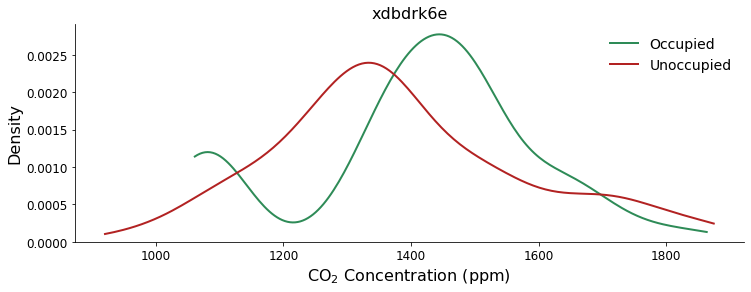

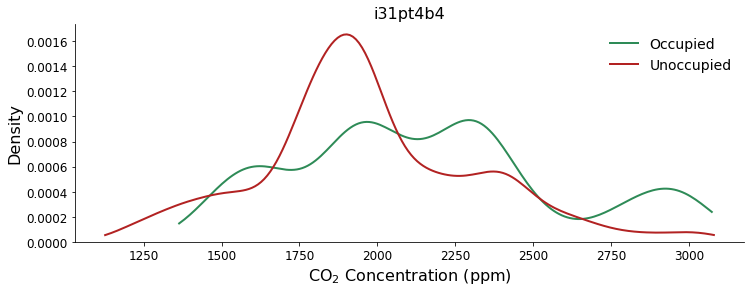

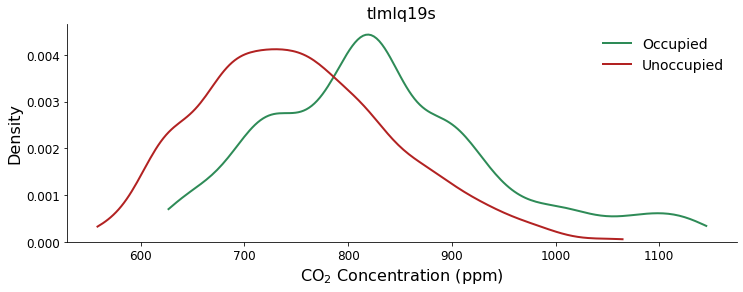

In [12]:
process_data.iaq_comparison(occ_label="occupied")

<div class="alert-block alert alert-warning">
    
The differences in `co2` distributions are not as stark as I would have hoped and for some participants, the differences are _opposite_ what I would have expected (lower concentrations during occupied periods). 
<div>

## TVOC Distributions for Occupied vs Unoccupied Periods
Now we look at the TVOC concentrations which, like `co2` should increase for occupied periods since the sensors appear sensitive to human-related VOCs.

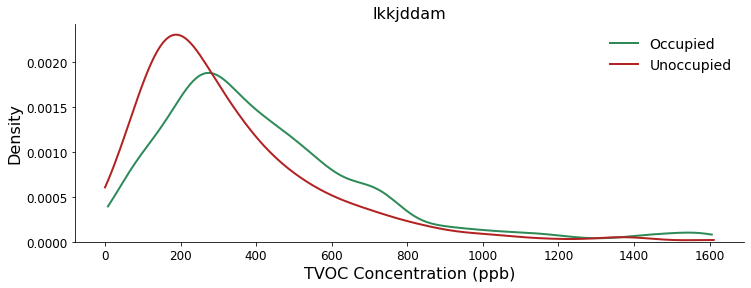

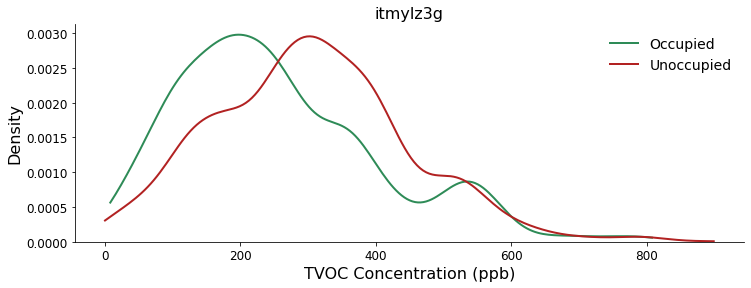

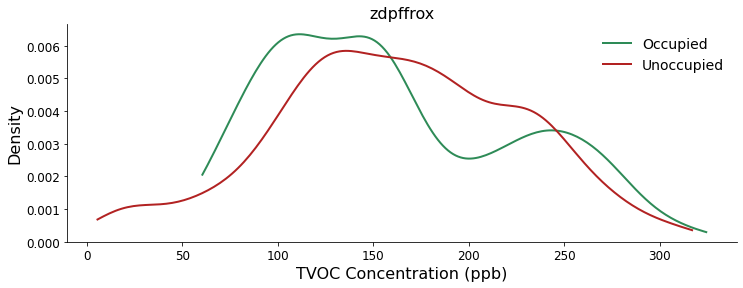

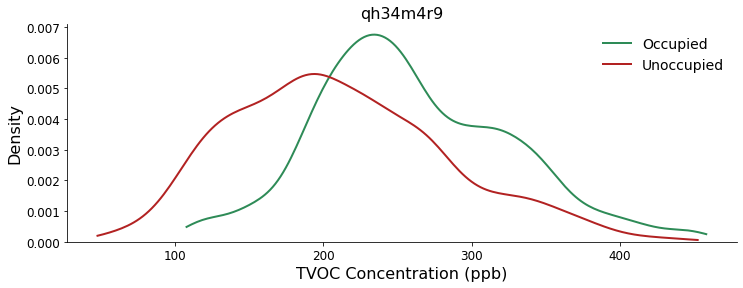

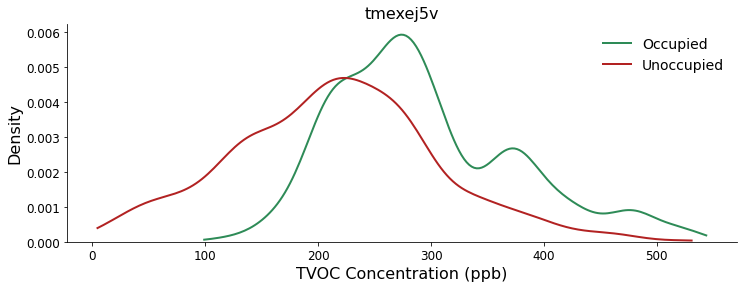

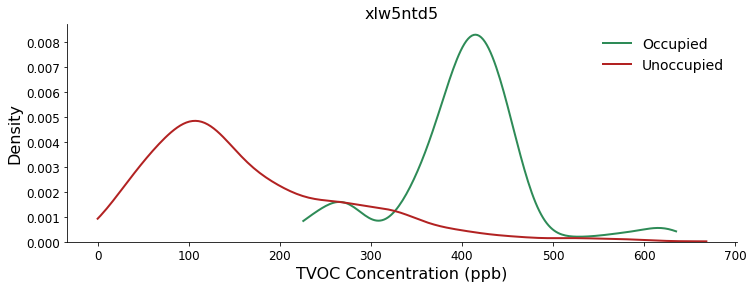

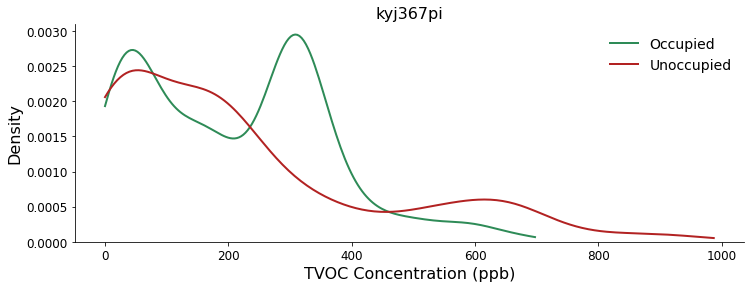

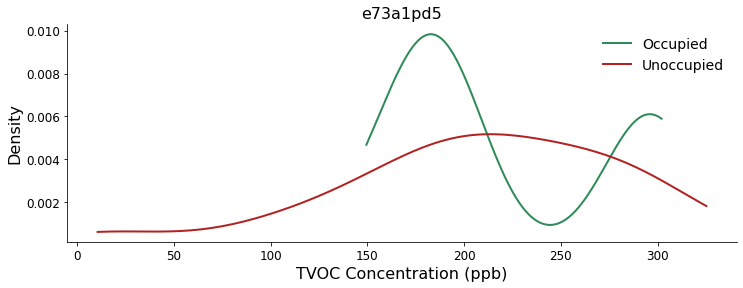

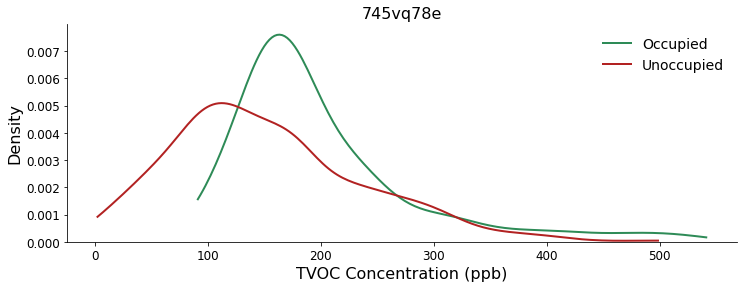

/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


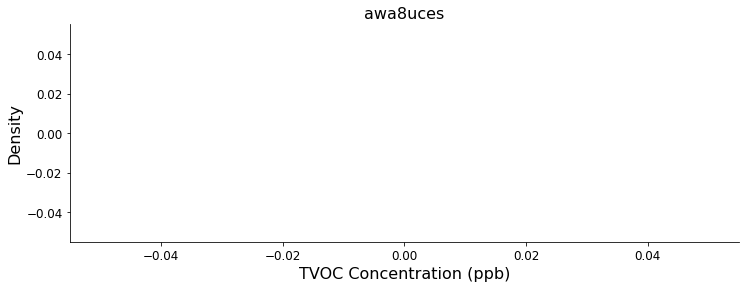

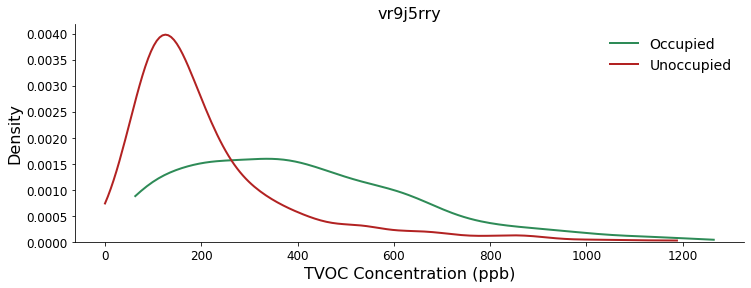

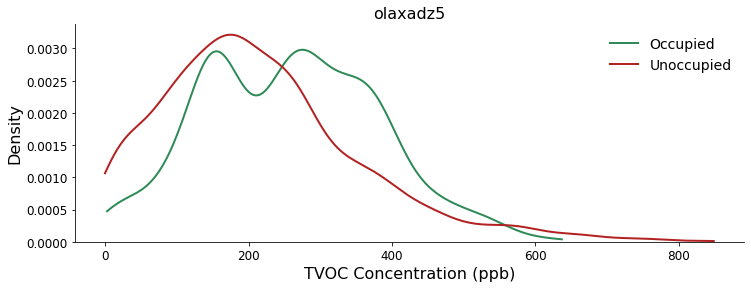

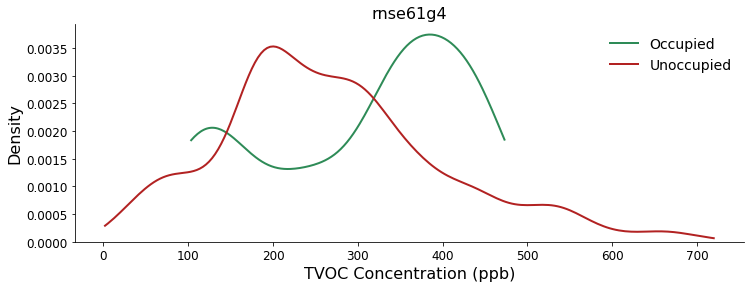

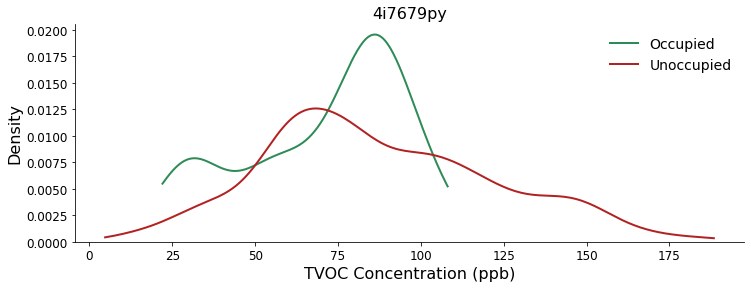

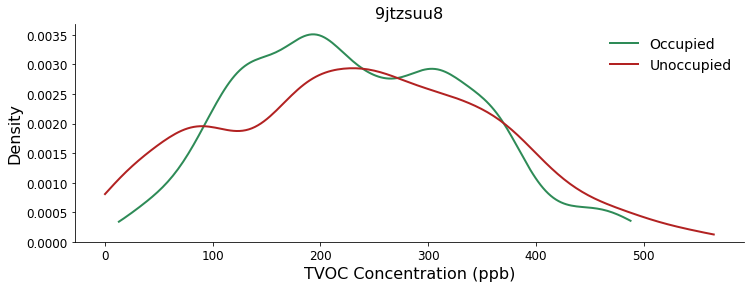

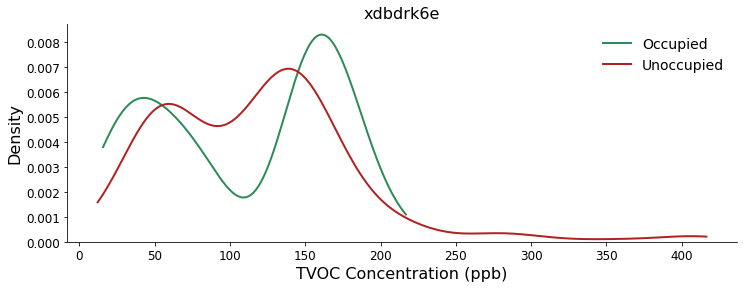

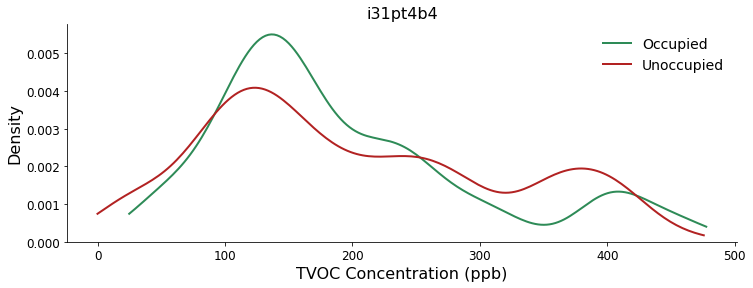

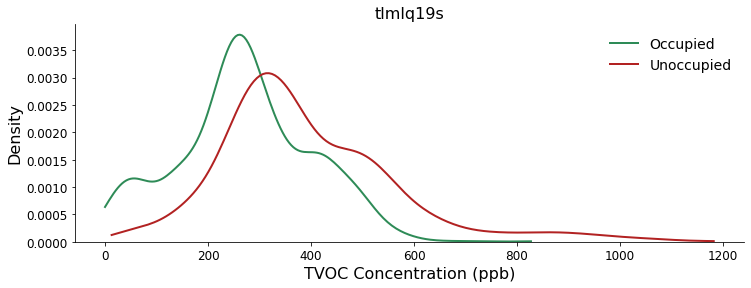

In [13]:
process_data.iaq_comparison(iaq_param="tvoc",)

## Hypothesis
The following participants should have data that we can use to accurately predict occupancy:
* xlw5ntd5
* olaxadz5

---

<a id="model_dev"></a>

# Model Development
Here we go through the different models in an attempt to determine which parameters are optimal across all participants and which classifier is best overall.

In [233]:
run_optimization = True
model = occupancy_detection.Classify(process_data.data,features=["co2","tvoc"])

/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


1. [Logistic Regression](#lr)
2. [Naive Bayes](#nb)
3. [Random Forest](#rf)
4. [MLP](#mlp)

<a id="lr"></a>

# Logistic Regression
We start with one of the simplest classifiers.

[LR with SKlearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression)

## Optimize
There are not too many hyperparameters to consider for the LR model, but we look at:

* `fit_intercept`
* `solver`

In [237]:
lr_param_dict={
    "fit_intercept": [True,False],
    "solver": ["lbfgs","liblinear"]
}
if run_optimization:
    lr_classification, lr_best_model_params = model.optimize(LogisticRegression,lr_param_dict,target="bedroom")
    
    print(lr_best_model_params)

Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.843
		Best Params
			 {'model__fit_intercept': True, 'model__solver': 'lbfgs'}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.21 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.669
		Best Params
			 {'model__fit_intercept': True, 'model__solver': 'liblinear'}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.1 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.692
		Best Params
			 {'model__fit_intercept': False, 'model__solver': 'lbfgs'}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.12 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.764
		Best Params
			 {'model__fit_intercept': True, 'model__solver': 'lbfgs'}
	U

/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Best Score
			 0.63
		Best Params
			 {'model__fit_intercept': True, 'model__solver': 'lbfgs'}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.12 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.628
		Best Params
			 {'model__fit_intercept': False, 'model__solver': 'lbfgs'}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.13 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.622
		Best Params
			 {'model__fit_intercept': False, 'model__solver': 'lbfgs'}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.12 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.817
		Best Params
			 {'model__fit_intercept': True, 'model__solver': 'lbfgs'}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time

Optimal parameters for `co2`-only model seem to be:

```python
{"fit_intercept":True,"solver":"lbfgs"}
```

Optimal parameters for `co2` and `tvoc` model seem to be:

```python
{"fit_intercept":True,"solver":"lbfgs"}

## Classifying

In [238]:
model.run(model=LogisticRegression,model_params={"fit_intercept":True,"solver":"lbfgs"},target="bedroom")

Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.03 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	

/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [239]:
lr_res = model.results.sort_values("beiwe")

[Back to Model Development](#model_dev)

---

<a id="nb"></a>

# Naive-Bayes

[Naive Bayes on SKlearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

## Optimize
Unecessary for Naive-Bayes since there are no hyperparameters of importance to consider.

## Classifying

In [240]:
model.run(model=GaussianNB,model_params=None,target="bedroom")

Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.02 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.02 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.01 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	

/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [241]:
nb_res = model.results.sort_values("beiwe")

[Back to Model Development](#model_dev)

---

<a id="rf"></a>

# Random Forest Classifier
Now that we have processed the data, we can try our hand at classifying the occupancy starting with a RF model.

[RF Documentation on SKLearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest%20classifier#sklearn.ensemble.RandomForestClassifier)

## Optimize
We have quite a few hyperparameters we consider:

* `n_estimators`
* `criterion`
* `max_depth`
* `min_samples_leaf`
* `min_samples_split`

In [245]:
rf_param_dict={
    "n_estimators":[10,20,50],
    "criterion":["gini"],
    "max_depth":[10,15,20],
    "min_samples_leaf": [1], # 1 tends to be fine (default)
    "min_samples_split": [2], # 2 tends to be fine (default)
}
if run_optimization:
    rf_classification, rf_best_model_params = model.optimize(RandomForestClassifier,rf_param_dict,target="bedroom")

Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.858
		Best Params
			 {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 20}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 2.16 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.704
		Best Params
			 {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 10}
	Updating Parameters
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 1.84 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch
		Best Score
			 0.815
		Best Params
			 {'model__criterion': 'gini', 'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 20}
	Updating Parameters
	Making 

In [247]:
if run_optimization:
    print(rf_best_model_params)

    n_estimators criterion  max_depth  min_samples_leaf  min_samples_split  \
0             20      gini         10                 1                  2   
1             10      gini         10                 1                  2   
2             20      gini         15                 1                  2   
3             10      gini         10                 1                  2   
4             20      gini         10                 1                  2   
5             10      gini         10                 1                  2   
6             50      gini         20                 1                  2   
7             20      gini         20                 1                  2   
8             50      gini         15                 1                  2   
9             50      gini         10                 1                  2   
10            10      gini         10                 1                  2   
11            50      gini         10                 1         

### Focus on `n_estimators`
We have some inkling about the best options for the other parameters so in these cells we look at how much better accuracy we get by varying the `n_estimators` parameter.

In [248]:
if run_optimization:
    rf_estimator_res = {}
    for n_estimator in [10,20,50,75,100,125]:
        model.run(model=RandomForestClassifier,model_params={"n_estimators":n_estimator,"criterion":"entropy","max_depth":5,"min_samples_leaf":4,"min_samples_split":2},
              target="bedroom")
        rf_estimator_res[str(n_estimator)] = model.results.sort_values("beiwe")

Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.04 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.04 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.03 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.04 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.04 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.03 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.03 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	

	Evaluating Classifier

Done - Time for Evaluation: 0.13 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.13 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.17 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.21 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.13 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.16 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.1 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.15 seconds
Start

In [249]:
if run_optimization:
    for key in rf_estimator_res.keys():
        mean_runtime = np.mean(rf_estimator_res[key]["runtime"])
        mean_accuracy = np.mean(rf_estimator_res[key]["accuracy"])
        mean_std = np.std(rf_estimator_res[key]["accuracy"])
        print(f"{key}\n\tRuntime:\t{mean_runtime} s\n\tAccuracy:\t{mean_accuracy}\n\tDeviation:\t{mean_std}")

10
	Runtime:	0.031111111111111114 s
	Accuracy:	0.8097259509804382
	Deviation:	0.08563339273157028
20
	Runtime:	0.052222222222222246 s
	Accuracy:	0.8161667666410795
	Deviation:	0.08365529981264118
50
	Runtime:	0.1077777777777778 s
	Accuracy:	0.8161095437804248
	Deviation:	0.08286535323871325
75
	Runtime:	0.1577777777777778 s
	Accuracy:	0.8163045109171795
	Deviation:	0.08055451195133229
100
	Runtime:	0.31166666666666665 s
	Accuracy:	0.81668039610822
	Deviation:	0.08270071194251341
125
	Runtime:	0.27222222222222225 s
	Accuracy:	0.8168009411304865
	Deviation:	0.08395237421127368


<div class="alert-block alert alert-info">

There doesn't seem to be a clear winner, but 100 seems like a good middle ground between accuracy, runtime, and std. 
<div>

### Final Parameters - `co2`-only Model
The following were the steps taken to get to the list of optimal parameters below:

1. **Laundry List**: a list of varied parameters that got us to

```python
criterion = "entropy"
max_depth = 5
```

2. **Focus on `n_estimators`**: Looking at various number of estimators between 5 and 200, got us to:

```python
n_estimators = 100
```

3. **Splits**: With these three parameters figured out, we then moved on to the final parameters which didn't reveal anything substantial so we stick with the defaults:

```python
min_samples_leaf = 1
min_samples_split = 2
```

Therefore, the optimal parameters are:

```python
{"n_estimators":100,"criterion":"entropy","max_depth":5,"min_samples_leaf":1,"min_samples_split":2}
```

### Final Parameters - `co2` and `tvoc` Model
The following were the steps taken to get to the list of optimal parameters below:

1. **Laundry List**: a list of varied parameters that got us to

```python
criterion = "gini"
min_samples_leaf = 1
min_samples_split = 2
```

2. **Depth Laundry List**: performing a smaller laundry list but looking at different max depths 

```python
max_depth = 10
```

3. **Focus on `n_estimators`**: Looking at various number of estimators between 10 and 125. Accuracy and runtime seemed pretty similar but the std at 75 was slightly less than at 100. 

```python
n_estimators = 75
```

Therefore, the optimal parameters are:

```python
{"n_estimators":75,"criterion":"gini","max_depth":10,"min_samples_leaf":1,"min_samples_split":2}
```

## Classify

In [250]:
model.run(model=RandomForestClassifier,
          model_params={"n_estimators":75,"criterion":"gini","max_depth":10,"min_samples_leaf":1,"min_samples_split":2},
          target="bedroom")

Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.24 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.18 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.14 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.2 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.17 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.16 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.12 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	E

In [251]:
rf_res = model.results.sort_values("beiwe")

[Back to Model Development](#model_dev)

---

<a id="mlp"></a>

# Multilayer Perceptron
An easy-to-implement neural network from SKlearn. 

[MLP on SKlearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlp#sklearn.neural_network.MLPClassifier)

## Optimize
We look at modifying the:

* `hidden_layer_sizes`
* `activation`
* `solver`

In [254]:
mlp_param_dict={
    "hidden_layer_sizes": [(4,16),(4,32),(8,16),(8,32)],
    "activation": ["relu","logistic"],
    "solver" : ["lbfgs"],
    "max_iter" : [2000]
}
if run_optimization:
    mlp_classification, mlp_best_model_params = model.optimize(MLPClassifier,mlp_param_dict,target="bedroom")
    
    print(mlp_best_model_params)

Starting...

	Creating Pipeline
	Splitting Data
	Performing Gridsearch


/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


KeyboardInterrupt: 

<div class="alert-block alert alert-info">

We should keep our MLP simple since increasing the amount of nodes will most likely not appreciably affect our accuracy and the cost to train is quite high. Not to mention that with more nodes, we sometimes do not converge.  
<div>

Optimal parameters for `co2`-only model are:

```python
{"hidden_layer_sizes":(4,16),"activation":"relu","solver":,"max_iter":2000}
```

## Classify

In [31]:
model.run(model=MLPClassifier,model_params={"hidden_layer_sizes":(4,16),"activation":"relu","solver":"lbfgs","max_iter":2000},target="bedroom")

Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.31 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.13 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.15 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.5 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.35 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.14 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.38 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	E

/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Evaluating Classifier

Done - Time for Evaluation: 0.12 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.08 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.15 seconds
Starting...

	Creating Pipeline
	Splitting Data
	Making Predictions
	Evaluating Classifier

Done - Time for Evaluation: 0.27 seconds


In [32]:
mlp_res = model.results.sort_values("beiwe")

[Back to Model Development](#model_dev)

---

<a id="comparison"></a>

[Back to ToC](#toc)
# Model Comparison
Now that we have the results from the various models, we can compare their various metrics.

In [33]:
res = {"lr":lr_res,"nb":nb_res,"rf":rf_res,"mlp":mlp_res}
comp = occupancy_detection.CompareModels(res)

<a id="predicting"></a>

## Scatter

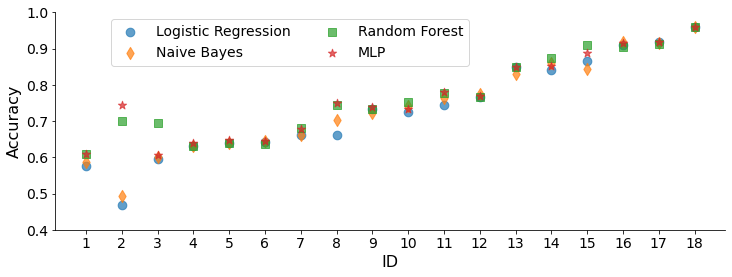

In [228]:
comp.scatter_metric(anonymize=True, save=False, annot="co2_only")

<div class="alert-block alert alert-info">

Looks like we have to make the tough decision between the RF and MLP models. We can look at runtime at the F1 score to make the final call.
<div>

## Runtime Comparison

In [46]:
comp.compare_runtimes()

RUNTIME:
	 LR
		Mean:	0.017222222222222222 s
		Sum:	0.31000000000000005 s
	 NB
		Mean:	0.013333333333333336 s
		Sum:	0.24000000000000002 s
	 RF
		Mean:	0.19666666666666666 s
		Sum:	3.54 s
	 MLP
		Mean:	0.20777777777777778 s
		Sum:	3.74 s


## F1 Scores

In [48]:
comp.compare_f1s()

F1:
	 LR
		Mean:	0.5490557269601731
		STD:	0.31489905704794885
	 NB
		Mean:	0.5594929267452234
		STD:	0.3160376111849615
	 RF
		Mean:	0.6480126125996406
		STD:	0.23912708922757075
	 MLP
		Mean:	0.6380813960160735
		STD:	0.2548667869662354


<div class="alert-block alert alert-success">

We choose: RF!
    
The runtime is slightly faster and the mean F1 scores are slightly higher with a smaller STD. Not to mention, the RF model can be explained more easily. 
<div>

## Saving

In [211]:
comp.save_results(annot="co2_only")

---

[Back to ToC](#toc)
# Predicting Occupancy
Now that we have created a few models, we want to predict whether or not some of the bedrooms are occupied for times when we have beacon data but no information regarding gps or Fitbit sleep episodes.

## Getting Data
Now we need all the data that we didn't use from earlier which shouldn't be too hard since we just need to find the data from `beeacon_all` that doesn't intersect with the data used for training/testing.

In [141]:
temp = process_data.beacon_all.reset_index().merge(process_data.data.reset_index()[["beiwe","timestamp"]],on=["beiwe","timestamp",],how="left",indicator=True)
unlabeled_data = temp[temp["_merge"] == "left_only"]
unlabeled_data.drop("_merge",axis=1,inplace=True)
unlabeled_data.set_index("timestamp",inplace=True)

## Getting Predictions

In [223]:
model.classify(model=RandomForestClassifier,model_params={"n_estimators":100,"criterion":"entropy","max_depth":5,"min_samples_leaf":1,"min_samples_split":2},
          observations=unlabeled_data, target="bedroom")

Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 0.18 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 0.2 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 0.26 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 0.21 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 0.22 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 0.24 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Eval

## Summarizing

In [208]:
model.summarize_classification(process_data.beacon_all)

Recovered Data with Probability of Occupancy Above 70.0%
	kyj367pi:	Available:	6597	Training:	1223 (18.5%)	Recovered:	3652 (55.4%)
	zdpffrox:	Available:	12349	Training:	1466 (11.9%)	Recovered:	548 (4.4%)
	xlw5ntd5:	Available:	13321	Training:	2398 (18.0%)	Recovered:	2071 (15.5%)
	i31pt4b4:	Available:	7010	Training:	2727 (38.9%)	Recovered:	219 (3.1%)
	9jtzsuu8:	Available:	7440	Training:	2118 (28.5%)	Recovered:	168 (2.3%)
	e73a1pd5:	Available:	1374	Training:	134 (9.8%)	Recovered:	492 (35.8%)
	qh34m4r9:	Available:	8339	Training:	3835 (46.0%)	Recovered:	1389 (16.7%)
	lkkjddam:	Available:	13635	Training:	3305 (24.2%)	Recovered:	8541 (62.6%)
	xdbdrk6e:	Available:	10166	Training:	495 (4.9%)	Recovered:	2560 (25.2%)
	vr9j5rry:	Available:	12706	Training:	1803 (14.2%)	Recovered:	374 (2.9%)
	awa8uces:	Available:	11346	Training:	1239 (10.9%)	Recovered:	5771 (50.9%)
	tmexej5v:	Available:	9948	Training:	2739 (27.5%)	Recovered:	3102 (31.2%)
	rnse61g4:	Available:	10151	Training:	3524 (34.7%)	Recovered:	

## Visuals

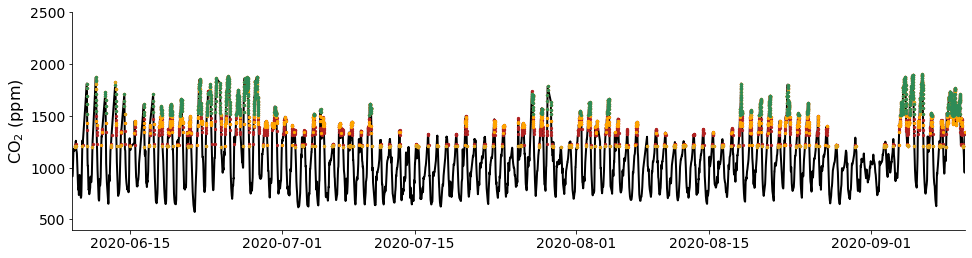

In [177]:
model.ts_prediction(participants=["xlw5ntd5"])

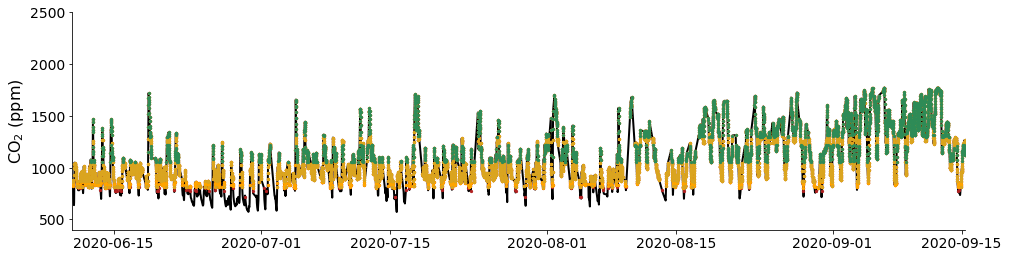

In [203]:
model.ts_prediction(participants=["lkkjddam"],save=False)

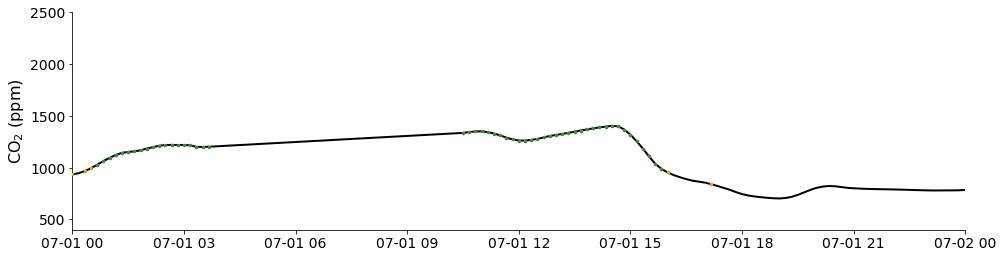

In [204]:
model.ts_prediction(participants=["awa8uces"],start_time=datetime(2020,7,1),end_time=datetime(2020,7,2), save=False)

### Insights

1. **Nightly Data Matches Labeled Data**: A quick check reveals that the data captured from sleep events with GPS data _do_ match the data labeled as "occupied".
2. **Single Feature Might not be Enough for RF**: This [figure](https://github.com/intelligent-environments-lab/utx000/blob/master/reports/figures/predicted_occupancy-lkkjddam.png) highlights that there might be certain ranges of concentrations that happen to be labeled unoccupied. The model still identifies these periods as occupied, but has less confidence that they are indeed occupied despite periods before and after with lower and higher co2 concentrations indicating occupancy. The RF model is rule-based so it is simply going to say that based on this range of concentrations, the room is a certain percent occupied. Perhaps if we include another variable, we can have a more sophisticated model that can more confidently identify these periods as occupied. 
3. **Are Training Data Representative?**: We might get into an issue where the training data do not represent the entire dataset well. There are many instances where we recover, with a probability of more than 70+%, more data than we used to train with. This is okay but we need to make sure that we are not predicting on data too far outside what was used to train the models with. 
4. **Periods Before and After Sleep**: This [figure](https://github.com/intelligent-environments-lab/utx000/blob/master/reports/figures/predicted_occupancy-awa8uces.png) highlights some likely prediction i.e. participants are likely occupying the bedroom before and after their sleep episode. 

## Saving

In [226]:
model.save_classifications(model_name="rf",annot="co2_only")

---